 # Deuteron
 The deuteron is the bound state of a proton and a neutron. In order to estimate the binding energy of the system, there are two main approaches one could follow involving a simulation on a quantum computer. 
 
 Here's a list of contents:
1. [First approach: EFT Hamiltonian](#first-approach-eft-hamiltonian)
    1. [Exact energies](#exact-energies)
    2. [Simulated energies](#simulated-energies)
       1. [N=2 simulation](#simulation-on-2-qubits)
       2. [N=3 simulation](#simulation-on-3-qubits)
       3. [Fit for ground state energy](#fit-for-ground-state-energy)
2. [Second approach: relative mixing of partial waves](#second-approach-relative-mixing-of-partial-waves)
3. [Read-out error mitigation](#noise-and-error-mitigation)
   1. [Noisy relative mixing](#noisy-relative-mixing)
   2. [Noisy 2 qubits EFT Hamiltonian](#noisy-2-qubits-eft-hamiltonian)
## First approach: EFT Hamiltonian
The creation and destruction operators of the deuteron are mapped into combinations of Pauli gates. The ladder operators $a_n^\dagger$ and $a_n$ create and annihilate a deuteron in the harmonic oscillator state $|n \rangle$. The Hamiltonian (from pionless effective field theory) is of the form

$$
H_N = \sum_{n,n'=0}^{N-1} \langle n' | T+V | n \rangle a_{n'}^\dagger a_n
$$

where the matrix elements are given by

$$
\langle n' |T|n\rangle = \frac{\hbar \omega}{2}\left[(2n+3/2)\delta_n^{n'}- \sqrt{n(n+ 1/2)}\delta_n^{n'+1}-\sqrt{(n+1)(n+3/2)}\delta_n^{n'-1} \right]
$$

$$
\langle n' |V|n\rangle = V_0 \delta_n^0 \delta_n^{n'}
$$

with $\hbar \omega= 7 \,\mathrm{MeV}$ and $V_0 =-5.68658111\,\mathrm{MeV}$.

Thanks to the Jordan-Wigner transformation, the Hamiltonian is expressed in terms of Pauli matrices, allowing us to map it into a quantum circuit with $N$ qubits. By calculating the variational ground state energies for $H_1$, $H_2$ and $H_3$, one can extrapolate the infinite-basis binding energy using the harmonic oscillator variant of Lüscher formula.

The reduced mass of the system is defined as $\mu = \frac{m_p m_n}{m_p + m_n}$, where $m_p$ and $m_n$ are the masses (in Mev) of the proton and the neutron respectively.

In [1]:
import math
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister,IBMQ, transpile, execute, BasicAer
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit_aer import AerSimulator, noise
from qiskit.providers.fake_provider import FakeVigo
import qiskit.quantum_info as qi
from qiskit.opflow.primitive_ops import MatrixOp
from scipy import linalg
from qiskit.quantum_info import Statevector, Pauli
from qiskit_aer import Aer
from qiskit.opflow import X, Y, Z, I, CircuitStateFn
from qiskit.visualization import plot_histogram
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
pi = math.pi
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from scipy.optimize import curve_fit
import re
# Deuteron parameters
m_p = 938.2720813 # MeV / c^2
m_n = 939.5654252 # MeV / c^2
mu = (m_p*m_n)/(m_p + m_n) # MeV / c^2
hbar_c = 197.326980 # Mev fm

/tmp/ipykernel_273/3934401402.py:15: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,


### Exact energies
By using the Qiskit Statevector method one can diagonalize the Hamiltonian and extract the exact energies of the system. Note how the use of the Qiskit library here is merely a matter of choice: what is happening is nothing more than complex matrix and vector moltiplication. These energies are going to be the reference point to compare the results of the actual simulation. This whole "Exact energies" chapter can be seen as a preliminary consistency check for the work done in the chapter "Simulated energies".

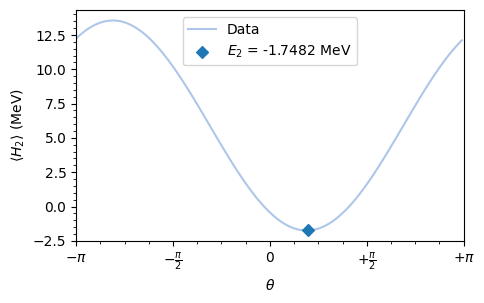

Lowest trial energy for N=1:  -0.4366 MeV
Lowest trial energy for N=2:  -1.7482 MeV
Lowest trial energy for N=3:  -2.0456 MeV


In [32]:
# Define deuterion Hamiltonian in the computational basis
Hamilt_1 = 0.218291 * (Z-I)
Hamilt_2 = (5.906709 * I^I) + (0.218291 * I^Z) - (6.125 * Z^I) - (2.143304 * X^X) - (2.143304 * Y^Y)
Hamilt_3 = (5.906709 * I^I^I) + (0.218291 * I^I^Z) - (6.125 * I^Z^I) - (2.143304 * I^X^X) - (2.143304 * I^Y^Y) +\
            + 9.625*(I^I^I) -9.625*(Z^I^I) - 3.913119*(X^X^I)  - 3.913119*(Y^Y^I)
# The ground state for H_1 is obtained as <1|H_1|1>, no need to use variational method
state = Statevector.from_int(1,2)
E_1_ex =  state.expectation_value(Hamilt_1).real 

# Loop over variational parameter theta for cal culation of <H_2>
theta = np.arange(-3.14,+3.14,0.05)
eta =  np.arange(-3.14,+3.14,0.05)
exp_val_2 = np.empty(len(theta))
exp_val_3 = np.empty((len(theta),len(eta)))
for kk in range(0, len(theta)):
    # Create a Quantum Circuit acting on the q register, default both in the state |0>
    circuit2 = QuantumCircuit(2)

    # Add X gate to qubit 0
    circuit2.x(0)

    # Rotation around y axis on qubit 1
    circuit2.ry(theta[kk], 1)

    # Add CNOT, control q1, target q0
    circuit2.cx(1,0)

    # Initialize state
    state2= Statevector.from_int(0, 4)

    # Evolve the state by the quantum circuit
    state2 = state2.evolve(circuit2)

    # Calculate expectation value
    exp_val_2[kk]=state2.expectation_value(Hamilt_2).real

    # loop over variational parameter eta for <H_3>
    for jj in range(0, len(eta)):
        # Create a Quantum Circuit acting on the q register, default all 3 qubits in the state |0>
        circuit3 = QuantumCircuit(3)

        # Add X gate to qubit 0
        circuit3.x(0)

        # Rotation around y axis on qubit 1
        circuit3.ry(eta[jj], 1)

        # Rotation around y axis on qubit 2
        circuit3.ry(theta[kk], 2)

        # Add CNOT, control q2, target q0
        circuit3.cx(2,0)

        # Add CNOT, control q0, target q1
        circuit3.cx(0,1)

        # Rotation around y axis on qubit 1
        circuit3.ry(-eta[jj], 1)

        # Add CNOT, control q0, target q1
        circuit3.cx(0,1)

        # Add CNOT, control q1, target q0
        circuit3.cx(1,0)

        # Initialize state
        state3= Statevector.from_int(0, 8)

        # Evolve the state by the quantum circuit
        state3 = state3.evolve(circuit3)

        # Calculate expectation value
        exp_val_3[kk, jj]=state3.expectation_value(Hamilt_3).real


# Lowest trial energy for <H_2> and <H_3>
E_2_ex = exp_val_2.min()
E_3_ex = exp_val_3.min()

# Plot of energy as a function of theta
# Plot style options
cmap = plt.get_cmap('tab20')
w = 5
h = 3
fontsize = 12
lbl = '$E_2$ = ' + str(round(E_2_ex,4))+' MeV'
fig = plt.figure(figsize=(w,h))
ax = fig.add_subplot(111)
ax.plot(theta, exp_val_2, color = cmap(1), label = 'Data')
ax.scatter(theta[np.where(exp_val_2 == E_2_ex)[0]], E_2_ex, color = cmap(0), zorder=5, marker='D', label = lbl)
unit = 0.5
x_tick = np.arange(-1, +1 + unit, unit)
x_label = [r'$-\pi $', r'$-\frac{\pi}{2}$', r'$0$', r'$+\frac{\pi}{2}$', r'$+\pi$']
ax.set_xlim(theta.min(), theta.max())
ax.set_xticks(x_tick * pi)
ax.set_xticklabels(x_label, fontsize=10)
ax.minorticks_on()
plt.legend(loc='upper center')
plt.xlabel("$\\theta$")
plt.ylabel("$\\langle H_2 \\rangle$ (MeV)")
plt.show()
# Results
print('Lowest trial energy for N=1: ', round(E_1_ex, 4), 'MeV')
print('Lowest trial energy for N=2: ', round(E_2_ex, 4), 'MeV')
print('Lowest trial energy for N=3: ', round(E_3_ex, 4), 'MeV')

Fit for $E_N$ using Lüscher formula

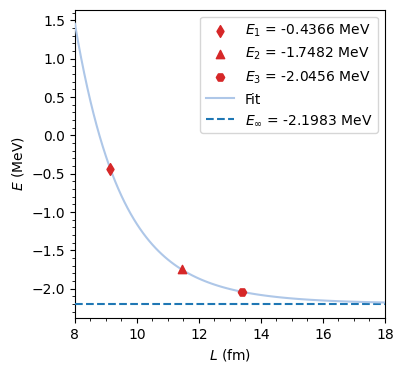

Infinite-basis extrapolated binding energy:  -2.1983 MeV ( 1.0 % off)


In [33]:
# List of trial energies
E_data = np.array([E_1_ex, E_2_ex, E_3_ex])

# Effective hard-wall radius for N=1, N=2 & N=3
L = np.array([9.14, 11.45, 13.38])  # fm

# Harmonic oscillator variant of Lüscher formula
#   k: bound state momentum fm^(-1)
#   gamma: asymptotic normalization coefficient fm^(-1/2)
def luscher(l, k, gamma):
    return -(hbar_c*hbar_c*k*k/(2*mu))*(1 - 2*gamma*gamma*np.exp(-2*k*l)/k - 4*(gamma**4)*l*np.exp(-4*k*l)/k)
            #hbar_c*hbar_c*k*gamma*gamma*(1- gamma*gamma/k - (gamma**4)/(4*k*k) + 2*w*k*(gamma**4))*np.exp(-4*k*l)/mu

# Fit to k and gamma
[k, gamma], cov = curve_fit(luscher, L, E_data)

# Fit plot
E_exact = -2.22 #MeV
ll = np.arange(8,18.0001,0.1)
lbl = '$E_\infty$ = ' + str(round(-hbar_c*hbar_c*k*k/(2*mu),4)) + ' MeV'
lbl1 = '$E_1$ = ' + str(round(E_data[0],4))+ ' MeV'
lbl2 = '$E_2$ = ' + str(round(E_data[1],4))+ ' MeV'
lbl3 = '$E_3$ = ' + str(round(E_data[2],4))+ ' MeV'
cmap = plt.get_cmap('tab20')
w = 4
h = 4
plt.figure(figsize=(w,h))
plt.scatter(L[0], E_data[0], color = cmap(6), marker = 'd', zorder=5, label = lbl1)
plt.scatter(L[1], E_data[1], color = cmap(6), marker = '^', zorder=5, label = lbl2)
plt.scatter(L[2], E_data[2], color = cmap(6), marker = 'H', zorder=5, label = lbl3)
plt.plot(ll, luscher(ll, k, gamma), color = cmap(1), zorder= 4, label= 'Fit')
plt.plot(ll, -hbar_c*hbar_c*k*k/(2*mu)*np.ones(len(ll)), '--', color = cmap(0), zorder = 3, label = lbl)
plt.legend()
plt.xlim(ll.min(), ll.max())
plt.minorticks_on()
plt.xlabel('$L$ (fm)')
plt.ylabel('$E$ (MeV)')
plt.show()
# Results
E_gs_0 = -hbar_c*hbar_c*k*k/(2*mu)
print('Infinite-basis extrapolated binding energy: ', round(E_gs_0,4), 'MeV (', round(np.abs(100*(E_exact -E_gs_0)/E_exact),1),'% off)' )

### Simulated energies
The Qiskit Qasm simulator is used to simulate the outcomes of an experiment measuring the different Pauli terms of the Hamiltonian under study. Note how the Pauli operators of the type $X \otimes X + Y\otimes Y$ for the 2 qubits circuit and $X \otimes X \otimes I + Y\otimes Y \otimes I$ for the 3 qubits circuit are measured all at once with a Bell measurement. The errors on the mean values are calculated assuming that each measurement can be seen as a sample from a binomial probability distribution.

In [2]:
# Simulator setup
Aer.backends()
# Transpile for simulator
simulator = Aer.get_backend('qasm_simulator')

backend = Aer.get_backend('qasm_simulator')

# Hamiltonians
Hamilt_1 = 0.218291 * (Z-I)
Hamilt_2 = (5.906709 * I^I) + (0.218291 * I^Z) - (6.125 * Z^I) - (2.143304 * X^X) - (2.143304 * Y^Y)
Hamilt_3 = (5.906709 * I^I^I) + (0.218291 * I^I^Z) - (6.125 * I^Z^I) - (2.143304 * I^X^X) - (2.143304 * I^Y^Y) +\
            + 9.625*(I^I^I) -9.625*(Z^I^I) - 3.913119*(X^X^I)  - 3.913119*(Y^Y^I)

#Measurement circuit ZZ
qc_meas_ZZ = QuantumCircuit(2)
qc_meas_ZZ.measure_all()
# Measurement circuit YY    
qc_meas_YY = QuantumCircuit(2)
qc_meas_YY.sdg(0)
qc_meas_YY.h(0)
qc_meas_YY.sdg(1)
qc_meas_YY.h(1)
qc_meas_YY.measure_all()
# Measurement circuit XX
qc_meas_XX = QuantumCircuit(2)
qc_meas_XX.h(0)
qc_meas_XX.h(1)
qc_meas_XX.measure_all()
#Measurement circuit Bell states
qc_meas_Bell = QuantumCircuit(2)
qc_meas_Bell.cx(0,1)
qc_meas_Bell.h(0)
qc_meas_Bell.measure_all()
#Measurement circuit Z
qc_meas_ZZZ = QuantumCircuit(3)
qc_meas_ZZZ.measure_all()
# Measurement circuit YYY    
qc_meas_YYY = QuantumCircuit(3)
qc_meas_YYY.sdg(0)
qc_meas_YYY.h(0)
qc_meas_YYY.sdg(1)
qc_meas_YYY.h(1)
qc_meas_YYY.sdg(2)
qc_meas_YYY.h(2)
qc_meas_YYY.measure_all()
# Measurement circuit XXX
qc_meas_XXX = QuantumCircuit(3)
qc_meas_XXX.h(0)
qc_meas_XXX.h(1)
qc_meas_XXX.h(2)
qc_meas_XXX.measure_all()

# Function that assigns 0 value to undefined keys in the counts dictionary
def check_counts_1(dic):
    if '1' not in dic:
        dic['1'] = 0
    if '0' not in dic:
        dic['0'] = 0

def check_counts_2(dic):
    if '11' not in dic:
        dic['11'] = 0
    if '10' not in dic:
        dic['10'] = 0
    if '01' not in dic:
        dic['01'] = 0
    if '00' not in dic:
        dic['00'] = 0

def check_counts_3(dic):
    if '111' not in dic:
        dic['111'] = 0
    if '101' not in dic:
        dic['101'] = 0
    if '011' not in dic:
        dic['011'] = 0
    if '001' not in dic:
        dic['001'] = 0
    if '110' not in dic:
        dic['110'] = 0
    if '100' not in dic:
        dic['100'] = 0
    if '010' not in dic:
        dic['010'] = 0
    if '000' not in dic:
        dic['000'] = 0

#### Simulation on 2 qubits

N=2 binding energy:  -1.7848  +-  0.0187  MeV


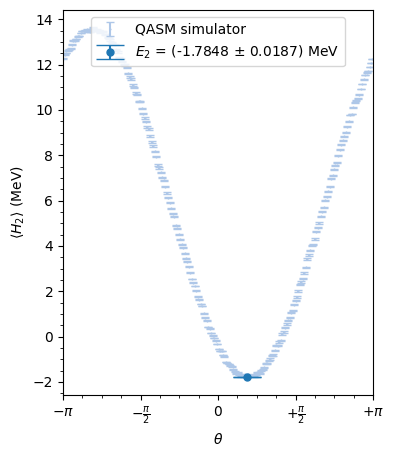

In [29]:
# Number of runs per simulation
shots = 10000

theta = np.arange(-3.14,+3.14,0.03)
exp_val_2 = np.empty(len(theta))
var_tot = np.empty(len(theta))
std_tot = np.empty(len(theta))
dexp_val_2 = np.empty(len(theta))
circuits_ZZ = []
circuits_Bell = []


# Prepare circuits
for kk in range(0, len(theta)):
    # Create a Quantum Circuit acting on the q register, default both in the state |0>
    qc2 = QuantumCircuit(2)

    # Add X gate to qubit 0
    qc2.x(0)

    # Rotation around y axis on qubit 1
    qc2.ry(theta[kk], 1)

    # Add CNOT, control q1, target q0
    qc2.cx(1,0)

    # Add measurement circuit
    qc2_ZZ = qc2.compose(qc_meas_ZZ)
    qc2_Bell = qc2.compose(qc_meas_Bell)
    # Transpile for simulator
    comp_qc2_ZZ = transpile(qc2_ZZ, simulator)
    comp_qc2_Bell = transpile(qc2_Bell, simulator)

    circuits_ZZ.append(comp_qc2_ZZ)
    circuits_Bell.append(comp_qc2_Bell)

job_ZZ = execute(circuits_ZZ, backend, shots=shots)
job_Bell = execute(circuits_Bell, backend, shots=shots)

# !!!!CHECK STATUS HERE!!!!
job_ZZ.wait_for_final_state()
job_Bell.wait_for_final_state()

# get results
result_ZZ = job_ZZ.result()
result_Bell = job_Bell.result()

# Get expectation values
for kk in range(0, len(theta)):
    counts_ZZ = job_ZZ.result().get_counts(circuits_ZZ[kk])
    check_counts_2(counts_ZZ)
    # Calculate expectation values & variances
    exp_IZ = (counts_ZZ['10'] + counts_ZZ['00'] - counts_ZZ['11'] - counts_ZZ['01'])/shots
    exp_ZI =  (counts_ZZ['01'] + counts_ZZ['00'] - counts_ZZ['11']- counts_ZZ['10'])/shots
    var_IZ = (counts_ZZ['10'] + counts_ZZ['00'])*(counts_ZZ['11'] + counts_ZZ['01'])/(shots**2)
    var_ZI = (counts_ZZ['01'] + counts_ZZ['00'])*(counts_ZZ['11'] + counts_ZZ['10'])/(shots**2)
    exp_val_2[kk] = 0.218291*exp_IZ - 6.125*exp_ZI + 5.906709
    var_tot[kk] = (0.218291**2)*var_IZ + (6.125**2)*var_ZI
for kk in range(0, len(theta)):
    counts_Bell = job_Bell.result().get_counts(circuits_Bell[kk])
    check_counts_2(counts_Bell)
    # Calculate expectation values & variances
    exp_XX_YY = 2*(counts_Bell['10'] - counts_Bell['11'])/shots 
    var_XX_YY = (counts_Bell['10'])*(counts_Bell['11'])/(shots**2)
    exp_val_2[kk] -= 2.143304*(exp_XX_YY)
    var_tot[kk] +=  (2.143304**2)*var_XX_YY

dexp_val_2= np.sqrt(var_tot/shots)

# Lowest trial energy for <H_2>
E_2 = exp_val_2.min()
dE_2= dexp_val_2[np.where(exp_val_2 == E_2)][0].astype(E_2)
print('N=2 binding energy: ', round(E_2,4), ' +- ', round(dE_2,4), ' MeV')

# Plot of energy as a function of theta  <H_2>(theta)
# Plot style options
cmap = plt.get_cmap('tab20')
w = 4
h = 5
fontsize = 12
lbl = '$E_2$ = (' + str(round(E_2,4)) + ' $\pm$ ' + str(round(dE_2,4)) + ') MeV'
fig = plt.figure(figsize=(w,h))
ax = fig.add_subplot(111)
ax.errorbar(theta, exp_val_2, yerr = dexp_val_2, color = cmap(1), fmt="o", ms=0.5, capsize = 3, label = 'QASM simulator')
ax.errorbar(theta[np.where(exp_val_2 == E_2)[0]], E_2, yerr = dE_2, color = cmap(0), fmt="o",zorder=5, ms=5, capsize = 10, label = lbl)
unit = 0.5
x_tick = np.arange(-1, +1 + unit, unit)
x_label = [r'$-\pi $', r'$-\frac{\pi}{2}$', r'$0$', r'$+\frac{\pi}{2}$', r'$+\pi$']
ax.set_xlim(theta.min(), theta.max())
ax.set_xticks(x_tick * pi)
ax.set_xticklabels(x_label, fontsize=10)
ax.minorticks_on()
plt.legend(loc='upper center')
plt.xlabel("$\\theta$")
plt.ylabel("$\\langle H_2 \\rangle$ (MeV)") 
plt.show()

# Save data for further comparison
exp_val_2_ideal = exp_val_2
dexp_val_2_ideal = dexp_val_2
E_gs_2_ideal = exp_val_2.min()
dE_gs_2_ideal = dexp_val_2[np.where(exp_val_2 == E_gs_2_ideal)][0].astype(float)


#### Simulation on 3 qubits

N=3 binding energy:  -2.07  +-  0.02  MeV


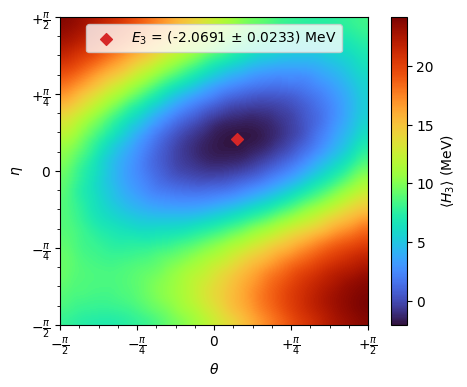

In [29]:
# Number of runs per simulation
shots = 10000

theta = np.arange(-3.14/2.,3.14/2. + 0.1, 0.1)
eta = np.arange(-3.14/2.,3.14/2. + 0.1, 0.1)
exp_val_3 = np.empty((len(theta), len(eta)))
dexp_val_3 = np.empty((len(theta), len(eta)))
var_tot = np.empty((len(theta),len(eta)))

circuits_ZZZ = []
circuits_Bell = []
circuits_Bell2 = []

# Prepare circuits
for kk in range(0, len(theta)):
    for jj in range(0, len(eta)):
        # Create a Quantum Circuit acting on the q register, default all 3 qubits in the state |0>
        qc3 = QuantumCircuit(3)

        # Add X gate to qubit 0
        qc3.x(0)

        # Rotation around y axis on qubit 1
        qc3.ry(eta[jj], 1)

        # Rotation around y axis on qubit 2
        qc3.ry(theta[kk], 2)

        # Add CNOT, control q2, target q0
        qc3.cx(2,0)

        # Add CNOT, control q0, target q1
        qc3.cx(0,1)

        # Rotation around y axis on qubit 1
        qc3.ry(-eta[jj], 1)

        # Add CNOT, control q0, target q1
        qc3.cx(0,1)

        # Add CNOT, control q1, target q0
        qc3.cx(1,0)
        
        # Add measurement circuit
        qc3_ZZZ = qc3.compose(qc_meas_ZZZ)
        qc3_Bell = qc3.compose(qc_meas_Bell, qubits=[0,1])
        qc3_Bell2 = qc3.compose(qc_meas_Bell, qubits=[1,2])
        # Transpile for simulator
        comp_qc3_ZZZ = transpile(qc3_ZZZ, simulator)
        comp_qc3_Bell = transpile(qc3_Bell, simulator)
        comp_qc3_Bell2 = transpile(qc3_Bell2, simulator)

        circuits_ZZZ.append(comp_qc3_ZZZ)
        circuits_Bell.append(comp_qc3_Bell)
        circuits_Bell2.append(comp_qc3_Bell2)


job_ZZZ = execute(circuits_ZZZ, backend, shots=shots)
job_Bell = execute(circuits_Bell, backend, shots=shots)
job_Bell2 = execute(circuits_Bell2, backend, shots=shots)

# !!!!CHECK STATUS HERE!!!!
job_ZZZ.wait_for_final_state()
job_Bell.wait_for_final_state()
job_Bell2.wait_for_final_state()

# get results
result_ZZZ = job_ZZZ.result()
result_Bell = job_Bell.result()
result_Bell2 = job_Bell2.result()

# Get expectation values
for kk in range(0, len(theta)):
    for jj in range(0,len(eta)):
        counts_ZZZ = job_ZZZ.result().get_counts(circuits_ZZZ[kk*len(theta) + jj])
        check_counts_3(counts_ZZZ)
        # Calculate expectation values & variances
        exp_IIZ = (counts_ZZZ['110'] + counts_ZZZ['100'] + counts_ZZZ['010'] + counts_ZZZ['000'] \
                   -counts_ZZZ['111'] - counts_ZZZ['101'] - counts_ZZZ['011'] - counts_ZZZ['001'] )/shots
        exp_IZI = (counts_ZZZ['000'] + counts_ZZZ['100'] + counts_ZZZ['001'] + counts_ZZZ['101'] \
                   -counts_ZZZ['010'] - counts_ZZZ['110'] - counts_ZZZ['011'] - counts_ZZZ['111'] )/shots
        exp_ZII = (counts_ZZZ['000'] + counts_ZZZ['001'] + counts_ZZZ['011'] + counts_ZZZ['010'] \
                   -counts_ZZZ['100'] - counts_ZZZ['101'] - counts_ZZZ['111'] - counts_ZZZ['110'] )/shots
        var_IIZ = (counts_ZZZ['110'] + counts_ZZZ['100'] + counts_ZZZ['010'] + counts_ZZZ['000'])*\
                    (counts_ZZZ['111'] + counts_ZZZ['101'] + counts_ZZZ['011'] + counts_ZZZ['001'])/(shots**2)
        var_IZI = (counts_ZZZ['000'] + counts_ZZZ['100'] + counts_ZZZ['001'] + counts_ZZZ['101'])*\
                    (counts_ZZZ['010'] + counts_ZZZ['110'] + counts_ZZZ['011'] + counts_ZZZ['111'] )/(shots**2)
        var_ZII = (counts_ZZZ['000'] + counts_ZZZ['001'] + counts_ZZZ['011'] + counts_ZZZ['010'])*\
                    (counts_ZZZ['100'] + counts_ZZZ['101'] + counts_ZZZ['111'] + counts_ZZZ['110']  )/(shots**2)
        exp_val_3[kk][jj] = 15.531709 + (0.218291 * exp_IIZ) - (6.125 * exp_IZI) -9.625*exp_ZII 
        var_tot[kk][jj] = (0.218291**2)*var_IIZ + (6.125**2)*var_IZI + (9.625**2)*var_ZII
for kk in range(0, len(theta)):
    for jj in range(0,len(eta)):
        counts_Bell = job_Bell.result().get_counts(circuits_Bell[kk*len(theta) + jj])
        check_counts_2(counts_Bell)
        # Calculate expectation values & variances
        exp_I_XX_YY = 2*(counts_Bell['10'] - counts_Bell['11'])/shots 
        var_I_XX_YY = (counts_Bell['10'])*(counts_Bell['11'])/(shots**2)
        exp_val_3[kk][jj] -=  2.143304*(exp_I_XX_YY) 
        var_tot[kk][jj] += (2.143304**2)*var_I_XX_YY
for kk in range(0, len(theta)):
    for jj in range(0,len(eta)):
        counts_Bell2 = job_Bell2.result().get_counts(circuits_Bell2[kk*len(theta) + jj])
        check_counts_2(counts_Bell2)
        # Calculate expectation values & variances
        exp_XX_YY_I = 2*(counts_Bell2['10'] - counts_Bell2['11'])/shots 
        var_XX_YY_I = (counts_Bell2['10'])*(counts_Bell2['11'])/(shots**2)
        exp_val_3[kk][jj] -=  3.913119*(exp_XX_YY_I)
        var_tot[kk][jj] += (3.913119**2)*var_XX_YY_I


dexp_val_3= np.sqrt(var_tot/shots)

E_3 = exp_val_3.min()
dE_3= dexp_val_3[np.where(exp_val_3 == E_3)][0].astype(E_3)
print('N=3 binding energy: ', round(E_3,2), ' +- ', round(dE_3,2), ' MeV')

# Plot
save_fig = True
cmap = mpl.cm.turbo
cmap2 = plt.get_cmap('tab20')
w = 6
h = 4
fontsize = 12
fig = plt.figure(figsize=(w,h))
ax = fig.add_subplot(111)
extent = [theta.min(),-theta.min(),eta.min(),-eta.min()]
exp_val_3T = exp_val_3.T
img = ax.imshow(exp_val_3T, extent=extent, cmap=cmap, interpolation='bicubic', origin='lower')
fig.colorbar(img, label = '$\\langle H_3 \\rangle$ (MeV)')
lbl = '$E_3$ = (' + str(round(E_3,4)) + ' $\pm$ '+ str(round(dE_3,4)) + ') MeV'
plt.scatter(theta[np.where(exp_val_3T==E_3)[1]], eta[np.where(exp_val_3T==E_3)[0]] , marker = 'D', color = cmap2(6), zorder = 3, label = lbl)
# ticks
unit = 0.25
x_tick = np.arange(-0.5, +0.5 + unit, unit)
x_label = [r'$-\frac{\pi}{2} $', r'$-\frac{\pi}{4}$', r'$0$', r'$+\frac{\pi}{4}$', r'$+\frac{\pi}{2}$']
ax.set_xticks(x_tick * pi)
ax.set_xticklabels(x_label, fontsize=10)
y_tick = np.arange(-0.5, +0.5 + unit, unit)
y_label = [r'$-\frac{\pi}{2} $', r'$-\frac{\pi}{4}$', r'$0$', r'$+\frac{\pi}{4}$', r'$+\frac{\pi}{2}$']
ax.set_yticks(y_tick * pi)
ax.set_yticklabels(y_label, fontsize=10)
ax.minorticks_on()
plt.legend(loc = 'upper center')
plt.xlabel("$\\theta$")
plt.ylabel("$\\eta$")
plt.show()

#### Fit for ground state energy
The energies obtained by truncating the harmonic oscillator ladder are related to the infinite-basis energy $E_\infty = E_{gs}= -\frac{\hbar^2 k^2}{2 \mu}$ thanks to the harmonic oscillator variant of Lüscher formula:

$$
E_N \approx -\frac{\hbar^2 k^2}{2 \mu} \left( 1 - 2 \frac{\gamma^2}{k} e^{-2kL} - 4 \frac{\gamma^4 L}{k} e^{-4kL}\right).
$$

By calculating $E_1$, $E_2$ and $E_3$ and knowing that the effective hard wall radii are $L_1 = 9.14\,\mathrm{fm}$, $L_2 = 11.45\,\mathrm{fm}$ and $L_3 = 13.38\,\mathrm{fm}$, one can fit the above formula with free paramters $k$ and $\gamma$ in order to obtain an estimate for the ground state energy $E_\infty$.

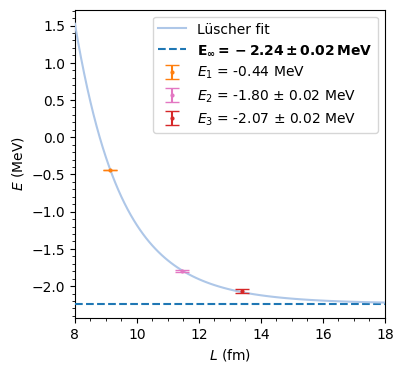

Infinite-basis extrapolated binding energy:  -2.2371  +-  0.0155  MeV ( 0.568 % off)


In [35]:
# List of trial energies
E_data = np.array([E_1_ex, E_2, E_3])
dE_data = np.array([0.001, dE_2, dE_3])
# Effective hard-wall radius for N=1, N=2 & N=3
L = np.array([9.14, 11.45, 13.38])  # fm

# Harmonic oscillator variant of Lüscher formula
#   k: bound state momentum fm^(-1)
#   gamma: asymptotic normalization coefficient fm^(-1/2)
def luscher(l, k, gamma):
    return -(hbar_c*hbar_c*k*k/(2*mu))*(1 - 2*gamma*gamma*np.exp(-2*k*l)/k - 4*(gamma**4)*l*np.exp(-4*k*l)/k)
            #hbar_c*hbar_c*k*gamma*gamma*(1- gamma*gamma/k - (gamma**4)/(4*k*k) + 2*w*k*(gamma**4))*np.exp(-4*k*l)/mu

# Fit to k and gamma
[k, gamma], cov = curve_fit(luscher, L, E_data, sigma = dE_data, absolute_sigma = True)
[dk, dgamma] = np.sqrt(np.diag(cov))
E_gs = -hbar_c*hbar_c*k*k/(2*mu)
dE_gs = hbar_c*hbar_c*k*dk/mu
#print(k, dk, gamma, dgamma)

# Fit plot
E_exact = -2.2245 #MeV
ll = np.arange(8,18.0001,0.1)
lbl = '$\\bf{E_\infty = ' + str("%.2f" % E_gs) + ' \pm ' + str("%.2f" % dE_gs) +'\,MeV}$'
lbl1 = '$E_1$ = ' + str("%.2f" % E_1_ex) + ' MeV'
lbl2 = '$E_2$ = ' + str("%.2f" % E_2) + ' $\pm$ ' + str("%.2f" % dE_2) + ' MeV'
lbl3 = '$E_3$ = ' + str("%.2f" % E_3) + ' $\pm$ ' + str("%.2f" % dE_3)+ ' MeV'
cmap = plt.get_cmap('tab20')
cmap2 = plt.get_cmap('tab20b')
w = 4
h = 4
plt.figure(figsize=(w,h))
plt.plot(ll, luscher(ll, k, gamma), color = cmap(1), zorder= 4, label= 'Lüscher fit')
plt.plot(ll, -hbar_c*hbar_c*k*k/(2*mu)*np.ones(len(ll)), '--', color = cmap(0), zorder = 3, label = lbl)
plt.errorbar(L[0], E_data[0], dE_data[0], color = cmap(2),fmt="o", ms=2, capsize = 5, zorder=5, linestyle = 'none',label = lbl1)
plt.errorbar(L[1], E_data[1], dE_data[1], color = cmap(12),fmt="o", ms=2, capsize = 5, zorder=5, linestyle = 'none',label = lbl2)
plt.errorbar(L[2], E_data[2], dE_data[2], color = cmap(6),fmt="o", ms=2, capsize = 5, zorder=5, linestyle = 'none',label = lbl3)
plt.legend()
plt.xlim(ll.min(), ll.max())
plt.minorticks_on()
plt.xlabel('$L$ (fm)')
plt.ylabel('$E$ (MeV)')
plt.show()
# Results
print('Infinite-basis extrapolated binding energy: ', round(E_gs,4), ' +- ', round(dE_gs,4),\
        ' MeV (', round(np.abs(100*(E_exact -E_gs)/E_exact),3),'% off)' )

## Second approach: relative mixing of partial waves

Since it is known that the parity of the ground state wave function of the deuteron is positive, one can conclude that the orbital angular momentum $L$ between the two nucleons has to be even. This is because the product of the intrinsic wave functions of the individual nucleons is positive regardless of the parity of each nucleon (which is the same for a proton and a neutron since they are different isospin states of a nucleon). In addition ot that, the total angular momentum of the ground state is $J=1$, meaning that the spin state must be a triplet state and therefore the only two allowed states are $^3 S_1$ and $^3 D_1$. From the Pauli exclusion principle, one can learn that in order to maintain the antisymmetric properties under exchange of the two nucleons the deuteron must be a isospin singlet ($T=0$). In general, the ground state of the deuteron will be a superposition of the only two allowed states $\ket{\phi_S}$ and $\ket{\phi_D}$:

$$
\ket{\psi} = \alpha \ket{\phi_S} + \beta \ket{\phi_D}.
$$

where $\alpha,\beta \in \mathbb{C}$ and $|\alpha|^2 + |\beta|^2 = 1$.

By introducing the relative mixing angle $\xi$, one can calculate the optimal mixing between the two partial waves by performing a rotation around the $y$ axis:

$$
\ket{\psi(\xi)} = \sin\left(\frac{\xi}{2}\right)\ket{\phi_S} + \cos\left(\frac{\xi}{2}\right) \ket{\phi_D} 
$$

The Hamiltonian is of the form:

$$
H = \left(\begin{matrix} \braket{\phi_S|H|\phi_S} & \braket{\phi_S|H|\phi_D} \\ \braket{\phi_D|H|\phi_S} & \braket{\phi_D|H|\phi_D}\end{matrix}\right) = \left(\begin{matrix} 5 & -35\\ 35 & 170\end{matrix}\right)= 87.5 I - 35 X + 82.5 Z
$$

where all numbers are in units of $\mathrm{MeV}$.

#### Simulation on 1 qubit

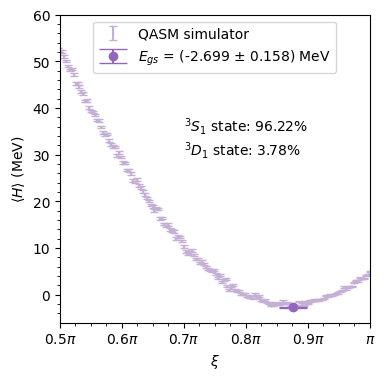

In [5]:
# Number of runs per simulation
shots = 20000

xi = np.arange(0.5,pi+0.01,0.01)
exp = np.empty(len(xi))
var = np.empty(len(xi))
dexp = np.empty(len(xi))
circuits_Z = []
circuits_X = []

# Measurement circuits
qc_meas_Z = QuantumCircuit(1)
qc_meas_Z.measure_all()
qc_meas_X = QuantumCircuit(1)
qc_meas_X.h(0)
qc_meas_X.measure_all()

# Prepare circuits
for kk in range(0,len(xi)):
    # Create a Quantum Circuit acting on the q register, default both in the state |0>
    qc1 = QuantumCircuit(1)

    # Prepare the state
    qc1.ry(xi[kk],0)
    # Add measurement circuit
    qc1_Z = qc1.compose(qc_meas_Z)
    qc1_X = qc1.compose(qc_meas_X)

    # Transpile for simulator
    comp_qc1_Z = transpile(qc1_Z, simulator)
    comp_qc1_X = transpile(qc1_X, simulator)


    circuits_Z.append(comp_qc1_Z)
    circuits_X.append(comp_qc1_X)

job_Z = execute(circuits_Z, backend, shots=shots)
job_X = execute(circuits_X, backend, shots=shots)

# !!!!CHECK STATUS HERE!!!!
job_Z.wait_for_final_state()
job_X.wait_for_final_state()

# get results
result_Z = job_Z.result()
result_X = job_X.result()

# Get expectation values
for kk in range(0, len(xi)):
    counts_Z = result_Z.get_counts(circuits_Z[kk])
    check_counts_1(counts_Z)
    # Calculate expectation values & variances
    exp_Z = (counts_Z['0'] - counts_Z['1'])/shots
    var_Z= counts_Z['0']*counts_Z['1']/(shots**2)
    exp[kk] = 87.5 + 82.5*exp_Z
    var[kk] = (82.5**2)*var_Z
for kk in range(0, len(xi)):
    counts_X = result_X.get_counts(circuits_X[kk])
    check_counts_1(counts_X)
    # Calculate expectation values & variances
    exp_X = (counts_X['0'] - counts_X['1'])/shots
    var_X= counts_X['0']*counts_X['1']/(shots**2)
    exp[kk] -= 35*exp_X
    var[kk] += (35**2)*var_X


dexp = np.sqrt(var/shots)

xi_0 = xi[np.where(exp == exp.min())][0].astype(float)
E_gs_pw = exp.min()
dE_gs_pw = dexp[np.where(exp == E_gs_pw)][0].astype(float)
# Plot of energy as a function of xi
# Plot style options
cmap = plt.get_cmap('tab20')
w = 4
h = 4
fontsize = 12
fig = plt.figure(figsize=(w,h))
lbl = '$E_{gs}$ = (' + str("%.3f" % E_gs_pw) + ' $\pm$ ' + str("%.3f" %  dE_gs_pw) + ') MeV'
xi_0 = xi[np.where(exp == exp.min())][0]
ax = fig.add_subplot(111)
ax.errorbar(xi, exp, yerr = dexp, color = cmap(9), fmt="o", ms=0.5, capsize = 3, label = 'QASM simulator')
ax.errorbar(xi_0, exp.min(), yerr= dexp[np.where(exp == exp.min())][0], color = cmap(8), fmt="o",zorder=5, ms=6, capsize = 10, label = lbl)
plt.xlabel("$\\xi$")
plt.ylabel("$\\langle H \\rangle$ (MeV)")

str_S= str("%.2f" % (100*np.sin(xi_0/2)**2))
str_D= str("%.2f" % (100*np.cos(xi_0/2)**2))
text = '$^3 S_1$ state: ' + str_S + '%\n$^3 D_1$ state: '  + str_D + '%'
plt.text(0.7*pi, 30,text)
unit = 0.1
x_tick = np.arange(0.5, 1. + unit, unit)
x_label = [r'$0.5 \pi $', r'$0.6 \pi $',r'$0.7 \pi $',r'$0.8 \pi $',r'$0.9 \pi $', r'$\pi$', r'']
ax.set_xticks(x_tick * pi)
ax.set_xticklabels(x_label, fontsize=10)
ax.minorticks_on()
plt.xlim(0.5*pi,pi)
plt.ylim(-6,60)
plt.legend(loc='upper center')
plt.show()

# Save data for further comparison
exp_ideal = exp
dexp_ideal = dexp
E_gs_ideal = exp.min()
dE_gs_ideal = dexp[np.where(exp == E_gs_pw)][0].astype(float)
xi_0_ideal = xi_0

#### Simulation on 2 qubits

In [4]:
# Number of runs per simulation
shots = 10000

xi = np.arange(0,2*pi+0.01,0.01)
exp2 = np.empty(len(xi))
var2 = np.empty(len(xi))
dexp2 = np.empty(len(xi))
circuits_ZZ = []
circuits_XX = []


## Prepare circuits
#for kk in range(0, len(xi)):
#    # Create a Quantum Circuit acting on the q register, default both in the state |0>
#    qc2 = QuantumCircuit(2)
#
#    # Add X gate to qubit 0
#    qc2.x(0)
#
#    # Rotation around y axis on qubit 1
#    qc2.ry(xi[kk], 1)
#
#    # Add CNOT, control q1, target q0
#    qc2.cx(1,0)
#
#    # Add measurement circuit
#    qc2_ZZ = qc2.compose(qc_meas_ZZ)
#    qc2_XX = qc2.compose(qc_meas_XX)
#    # Transpile for simulator
#    comp_qc2_ZZ = transpile(qc2_ZZ, simulator)
#    comp_qc2_XX = transpile(qc2_XX, simulator)
#
#    circuits_ZZ.append(comp_qc2_ZZ)
#    circuits_XX.append(comp_qc2_XX)
#
#job_ZZ = execute(circuits_ZZ, backend, shots=shots)
#job_XX = execute(circuits_XX, backend, shots=shots)
#
## !!!!CHECK STATUS HERE!!!!
#job_ZZ.wait_for_final_state()
#job_XX.wait_for_final_state()
#
## get results
#result_ZZ = job_ZZ.result()
#result_XX = job_XX.result()
#
## Get expectation values
#for kk in range(0, len(xi)):
#    counts_ZZ = job_ZZ.result().get_counts(circuits_ZZ[kk])
#    check_counts_2(counts_ZZ)
#    # Calculate expectation values & variances
#    exp_IZ = (counts_ZZ['10'] + counts_ZZ['00'] - counts_ZZ['11'] - counts_ZZ['01'])/shots
#    exp_ZI =  (counts_ZZ['01'] + counts_ZZ['00'] - counts_ZZ['11']- counts_ZZ['10'])/shots
#    var_IZ = (counts_ZZ['10'] + counts_ZZ['00'])*(counts_ZZ['11'] + counts_ZZ['01'])/(shots**2)
#    var_ZI = (counts_ZZ['01'] + counts_ZZ['00'])*(counts_ZZ['11'] + counts_ZZ['10'])/(shots**2)
#    exp2[kk] = 87.5 + 82.5*exp_ZI
#    var2[kk] = (82.5**2)*var_ZI
#for kk in range(0, len(xi)):
#    counts_XX = job_XX.result().get_counts(circuits_XX[kk])
#    check_counts_2(counts_XX)
#    # Calculate expectation values & variances
#    exp_IX = (counts_XX['10'] + counts_XX['00'] - counts_XX['11'] - counts_XX['01'])/shots
#    exp_XI =  (counts_XX['01'] + counts_XX['00'] - counts_XX['11']- counts_XX['10'])/shots
#    var_IX = (counts_XX['10'] + counts_XX['00'])*(counts_XX['11'] + counts_XX['01'])/(shots**2)
#    var_XI = (counts_XX['01'] + counts_XX['00'])*(counts_XX['11'] + counts_XX['10'])/(shots**2)
#    exp2[kk] -= 35*exp_XI
#    var2[kk] += (35**2)*var_XI
#
#dexp2 = np.sqrt(var2/shots)
#
#E_gs_pw = exp2.min()
#dE_gs_pw = dexp2[np.where(exp2 == E_gs_pw)][0].astype(E_gs_pw)
#xi_0 = xi[np.where(exp2 == E_gs_pw)][0].astype(E_gs_pw)
## Plot of energy as a function of xi
## Plot style options
#cmap = plt.get_cmap('tab20')
#w = 4
#h = 4
#fontsize = 12
#fig = plt.figure(figsize=(w,h))
#lbl = '$E_{gs}$ = (' + str("%.3f" % E_gs_pw) + ' $\pm$ ' + str("%.3f" %  dE_gs_pw) + ') MeV'
#ax = fig.add_subplot(111)
#ax.errorbar(xi, exp2, yerr = dexp2, color = cmap(5), fmt="o", ms=0.5, capsize = 3, label = 'Simulated data')
#ax.errorbar(xi_0, exp2.min(), yerr= dexp2[np.where(exp2 == exp2.min())][0], color = cmap(4), fmt="o",zorder=5, ms=6, capsize = 10, label = lbl)
#plt.xlabel("$\\xi$")
#plt.ylabel("$\\langle H \\rangle$ (MeV)")
#
#str_S= str("%.2f" % (100*np.sin(xi_0/2)**2))
#str_D= str("%.2f" % (100*np.cos(xi_0/2)**2))
#text = '$^3 S_1$ state: ' + str_S + '%\n$^3 D_1$ state: '  + str_D + '%'
#plt.text(0.7*pi, 30,text)
##unit = 0.25
##x_tick = np.arange(0.5, 1. + unit, unit)
##x_label = [r'$\frac{\pi}{2} $', r'$\frac{3\pi}{4}$', r'$\pi$']
##ax.set_xticks(x_tick * pi)
##ax.set_xticklabels(x_label, fontsize=10)
##ax.minorticks_on()
##plt.xlim(0.5*pi,pi)
##plt.ylim(-6,60)
#plt.legend(loc='upper center')
#plt.show()

## Noise and error mitigation
The focus is now to perform a noisy simulation of a few of the previously seen experiments, as an example of read-out quantum error mitigation.

In [10]:

# Noise model setup function
def setup_noise_model(n_qubits, p0, p1):
    # Generate a noise model for the qubits
    noise_model = noise.NoiseModel()
    for qi in range(n_qubits):
        read_err = noise.errors.readout_error.ReadoutError([[1-p0, p0],[p1, 1-p1]])
        noise_model.add_readout_error(read_err, [qi])
    return noise_model

# Function that calculates the matrix to apply to raw results
# in order to mitigate the read out error 
def read_out_correction(n_qubits, raw_result, shots, noise_model):
    
    # Calibration experiment
    qr = QuantumRegister(n_qubits)
    qubit_list = []
    for i in range(0, n_qubits):
        qubit_list.append(i)

    meas_calibs, state_labels = complete_meas_cal(qubit_list= qubit_list  , qr= qr, circlabel='mcal')
    # Execute the calibration circuits with noise
    job = execute(meas_calibs, backend=backend, shots=shots, noise_model= noise_model)
    cal_results = job.result()

    # Calibration matrix 
    meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
        
    # Results with mitigation
    mitigated_results = meas_fitter.filter.apply(raw_result)
    return mitigated_results


### Noisy relative mixing

<Figure size 1000x500 with 0 Axes>

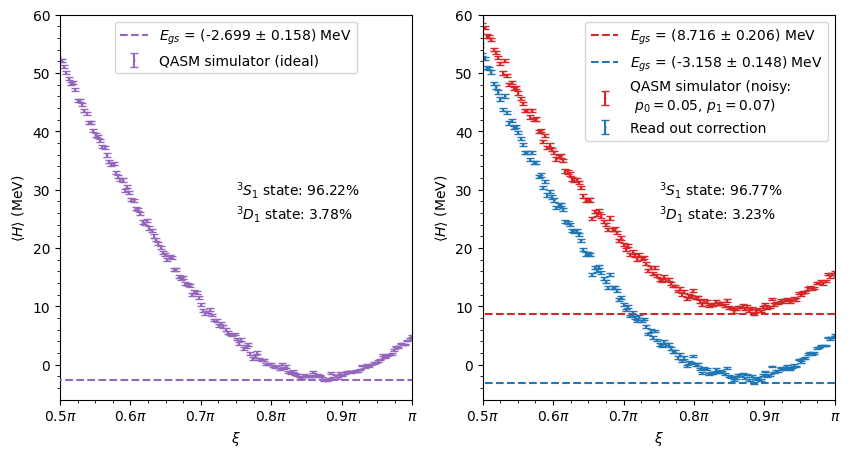

In [32]:

# Simulator setup
Aer.backends()
# Transpile for simulator
backend_ideal = Aer.get_backend('qasm_simulator')
#backend_noisy = AerSimulator.from_backend(device_backend)

# Example of read out error parameters
p0 = 0.05
p1 = 0.07


# Number of runs per simulation
shots = 20000

xi = np.arange(0.5,pi+0.01,0.01)
exp = np.empty(len(xi))
var = np.empty(len(xi))
dexp = np.empty(len(xi))
exp_mit = np.empty(len(xi))
var_mit = np.empty(len(xi))
dexp_mit = np.empty(len(xi))
circuits_Z = []
circuits_X = []

# Measurement circuits
qc_meas_Z = QuantumCircuit(1)
qc_meas_Z.measure_all()
qc_meas_X = QuantumCircuit(1)
qc_meas_X.h(0)
qc_meas_X.measure_all()

# Prepare circuits
for kk in range(0,len(xi)):
    # Create a Quantum Circuit acting on the q register, default both in the state |0>
    qc1 = QuantumCircuit(1)

    # Prepare the state
    qc1.ry(xi[kk],0)
    # Add measurement circuit
    qc1_Z = qc1.compose(qc_meas_Z)
    qc1_X = qc1.compose(qc_meas_X)

    # Transpile for simulator
    comp_qc1_Z = transpile(qc1_Z, simulator)
    comp_qc1_X = transpile(qc1_X, simulator)


    circuits_Z.append(comp_qc1_Z)
    circuits_X.append(comp_qc1_X)

# noise setup
noise_mod = setup_noise_model(1, p0,p1)

# jobs
job_Z = execute(circuits_Z, backend, shots=shots, noise_model = noise_mod)
job_X = execute(circuits_X, backend, shots=shots, noise_model = noise_mod)

# !!!!CHECK STATUS HERE!!!!
job_Z.wait_for_final_state()
job_X.wait_for_final_state()

# get results
result_Z = job_Z.result()
result_X = job_X.result()

# Get expectation values
for kk in range(0, len(xi)):
    counts_Z = result_Z.get_counts(circuits_Z[kk])
    check_counts_1(counts_Z)
    # Calculate expectation values & variances
    exp_Z = (counts_Z['0'] - counts_Z['1'])/shots
    var_Z= counts_Z['0']*counts_Z['1']/(shots**2)
    exp[kk] = 87.5 + 82.5*exp_Z
    var[kk] = (82.5**2)*var_Z
for kk in range(0, len(xi)):
    counts_X = result_X.get_counts(circuits_X[kk])
    check_counts_1(counts_X)
    # Calculate expectation values & variances
    exp_X = (counts_X['0'] - counts_X['1'])/shots
    var_X= counts_X['0']*counts_X['1']/(shots**2)
    exp[kk] -= 35*exp_X
    var[kk] += (35**2)*var_X


dexp = np.sqrt(var/shots)

# Apply read out correction to raw results
result_Z_mit = read_out_correction(1, result_Z, shots, noise_mod)
result_X_mit = read_out_correction(1, result_X, shots, noise_mod)

# Get expectation values
for kk in range(0, len(xi)):
    counts_Z = result_Z_mit.get_counts(circuits_Z[kk])
    check_counts_1(counts_Z)
    # Calculate expectation values & variances
    exp_Z = (counts_Z['0'] - counts_Z['1'])/shots
    var_Z= counts_Z['0']*counts_Z['1']/(shots**2)
    exp_mit[kk] = 87.5 + 82.5*exp_Z
    var_mit[kk] = (82.5**2)*var_Z
for kk in range(0, len(xi)):
    counts_X = result_X_mit.get_counts(circuits_X[kk])
    check_counts_1(counts_X)
    # Calculate expectation values & variances
    exp_X = (counts_X['0'] - counts_X['1'])/shots
    var_X= counts_X['0']*counts_X['1']/(shots**2)
    exp_mit[kk] -= 35*exp_X
    var_mit[kk] += (35**2)*var_X

dexp_mit = np.sqrt(var_mit/shots)


xi_0 = xi[np.where(exp == exp.min())][0].astype(float)
E_gs_pw = exp.min()
dE_gs_pw = dexp[np.where(exp == E_gs_pw)][0].astype(float)
E_gs_pw_mit = exp_mit.min()
dE_gs_pw_mit = dexp_mit[np.where(exp_mit == E_gs_pw_mit)][0].astype(float)

# Plot of energy as a function of xi
# Plot style options
cmap = plt.get_cmap('tab20')
w = 10
h = 5
fontsize = 12
fig = plt.figure(figsize=(w,h))
fig, axs = plt.subplots(1,2, figsize= (w,h), sharey = False)
lbl0 = '$E_{gs}$ = (' + str("%.3f" % E_gs_ideal) + ' $\pm$ ' + str("%.3f" %  dE_gs_ideal) + ') MeV'
lbl = '$E_{gs}$ = (' + str("%.3f" % E_gs_pw) + ' $\pm$ ' + str("%.3f" %  dE_gs_pw) + ') MeV'
lbl2 = '$E_{gs}$ = (' + str("%.3f" % E_gs_pw_mit) + ' $\pm$ ' + str("%.3f" %  dE_gs_pw_mit) + ') MeV'
lbl_error = 'QASM simulator (noisy:\n $p_0=$' + str("%.2f" % p0) + ', $p_1=$' + str("%.2f" % p1) +')'
xi_0 = xi[np.where(exp == exp.min())][0]
xi_0_mit = xi[np.where(exp_mit == exp_mit.min())][0]

axs[0].errorbar(xi, exp_ideal, yerr = dexp_ideal, color = cmap(8), fmt="o", ms=0.5, capsize = 3, label = 'QASM simulator (ideal)')
axs[0].plot(xi, np.ones(len(xi))*exp_ideal.min(), '--', color = cmap(8),zorder=5, label = lbl0)
axs[1].errorbar(xi, exp, yerr = dexp, color = cmap(6), fmt="o", ms=0.5, capsize = 3, label = lbl_error)
axs[1].errorbar(xi, exp_mit, yerr = dexp_mit, color = cmap(0), fmt="o", ms=0.5, capsize = 3, label = 'Read out correction')
axs[1].plot(xi, np.ones(len(xi))*exp.min(), '--', color = cmap(6),zorder=0, label = lbl)
axs[1].plot(xi, np.ones(len(xi))*exp_mit.min(), '--', color = cmap(0),zorder=5, label = lbl2)
axs[0].set(xlabel='$\\xi$', ylabel='$\\langle H \\rangle$ (MeV)')
axs[1].set(xlabel='$\\xi$', ylabel='$\\langle H \\rangle$ (MeV)')
#axs[1].label_outer()

str_S= str("%.2f" % (100*np.sin(xi_0/2)**2))
str_D= str("%.2f" % (100*np.cos(xi_0/2)**2))
text = '$^3 S_1$ state: ' + str_S + '%\n$^3 D_1$ state: '  + str_D + '%'
axs[1].text(0.75*pi, 25,text)

str_S= str("%.2f" % (100*np.sin(xi_0_ideal/2)**2))
str_D= str("%.2f" % (100*np.cos(xi_0_ideal/2)**2))
text = '$^3 S_1$ state: ' + str_S + '%\n$^3 D_1$ state: '  + str_D + '%'
axs[0].text(0.75*pi, 25,text)

unit = 0.1
x_tick = np.arange(0.5, 1. + unit, unit)
x_label = [r'$0.5 \pi $', r'$0.6 \pi $',r'$0.7 \pi $',r'$0.8 \pi $',r'$0.9 \pi $', r'$\pi$', r'']
axs[0].set_xticks(x_tick * pi)
axs[0].set_xticklabels(x_label, fontsize=10)
axs[1].set_xticks(x_tick * pi)
axs[1].set_xticklabels(x_label, fontsize=10)
axs[0].minorticks_on()
axs[1].minorticks_on()
axs[0].set_xlim(0.5*pi,pi)
axs[1].set_xlim(0.5*pi,pi)
axs[0].set_ylim(-6,60)
axs[1].set_ylim(-6,60)

axs[0].legend(loc='upper center')
axs[1].legend(loc='upper right') 
#plt.tight_layout()
plt.show()

### Noisy 2 qubits EFT Hamiltonian

<Figure size 1000x500 with 0 Axes>

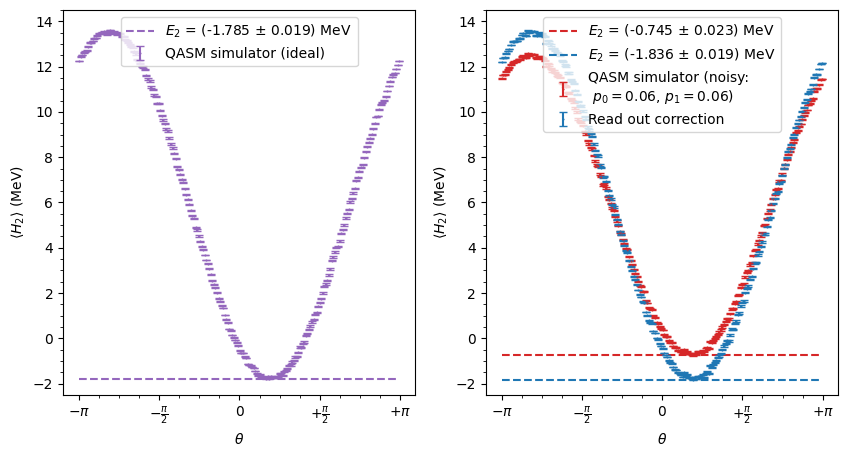

In [30]:
# Example of read out error parameters
p0 = 0.06
p1 = 0.06

# Number of runs per simulation
shots = 10000

theta = np.arange(-3.14,+3.14,0.03)
exp_val_2 = np.empty(len(theta))
var_tot = np.empty(len(theta))
std_tot = np.empty(len(theta))
dexp_val_2 = np.empty(len(theta))
exp_val_2_mit = np.empty(len(theta))
var_tot_mit = np.empty(len(theta))
dexp_val_2_mit = np.empty(len(theta))
circuits_ZZ = []
circuits_Bell = []


# Prepare circuits
for kk in range(0, len(theta)):
    # Create a Quantum Circuit acting on the q register, default both in the state |0>
    qc2 = QuantumCircuit(2)

    # Add X gate to qubit 0
    qc2.x(0)

    # Rotation around y axis on qubit 1
    qc2.ry(theta[kk], 1)

    # Add CNOT, control q1, target q0
    qc2.cx(1,0)

    # Add measurement circuit
    qc2_ZZ = qc2.compose(qc_meas_ZZ)
    qc2_Bell = qc2.compose(qc_meas_Bell)
    # Transpile for simulator
    comp_qc2_ZZ = transpile(qc2_ZZ, simulator)
    comp_qc2_Bell = transpile(qc2_Bell, simulator)

    circuits_ZZ.append(comp_qc2_ZZ)
    circuits_Bell.append(comp_qc2_Bell)

# noise setup
noise_mod = setup_noise_model(2, p0,p1)

job_ZZ = execute(circuits_ZZ, backend, shots=shots, noise_model =  noise_mod)
job_Bell = execute(circuits_Bell, backend, shots=shots, noise_model =  noise_mod)

# !!!!CHECK STATUS HERE!!!!
job_ZZ.wait_for_final_state()
job_Bell.wait_for_final_state()

# get results
result_ZZ = job_ZZ.result()
result_Bell = job_Bell.result()

# Get expectation values
for kk in range(0, len(theta)):
    counts_ZZ = result_ZZ.get_counts(circuits_ZZ[kk])
    check_counts_2(counts_ZZ)
    # Calculate expectation values & variances
    exp_IZ = (counts_ZZ['10'] + counts_ZZ['00'] - counts_ZZ['11'] - counts_ZZ['01'])/shots
    exp_ZI =  (counts_ZZ['01'] + counts_ZZ['00'] - counts_ZZ['11']- counts_ZZ['10'])/shots
    var_IZ = (counts_ZZ['10'] + counts_ZZ['00'])*(counts_ZZ['11'] + counts_ZZ['01'])/(shots**2)
    var_ZI = (counts_ZZ['01'] + counts_ZZ['00'])*(counts_ZZ['11'] + counts_ZZ['10'])/(shots**2)
    exp_val_2[kk] = 0.218291*exp_IZ - 6.125*exp_ZI + 5.906709
    var_tot[kk] = (0.218291**2)*var_IZ + (6.125**2)*var_ZI
for kk in range(0, len(theta)):
    counts_Bell = result_Bell.get_counts(circuits_Bell[kk])
    check_counts_2(counts_Bell)
    # Calculate expectation values & variances
    exp_XX_YY = 2*(counts_Bell['10'] - counts_Bell['11'])/shots 
    var_XX_YY = (counts_Bell['10'])*(counts_Bell['11'])/(shots**2)
    exp_val_2[kk] -= 2.143304*(exp_XX_YY)
    var_tot[kk] +=  (2.143304**2)*var_XX_YY

dexp_val_2= np.sqrt(var_tot/shots)


# Apply read out correction to raw results
result_ZZ_mit = read_out_correction(2, result_ZZ, shots, noise_mod)
result_Bell_mit = read_out_correction(2, result_Bell, shots, noise_mod)

# Get expectation values
for kk in range(0, len(theta)):
    counts_ZZ = result_ZZ_mit.get_counts(circuits_ZZ[kk])
    check_counts_2(counts_ZZ)
    # Calculate expectation values & variances
    exp_IZ = (counts_ZZ['10'] + counts_ZZ['00'] - counts_ZZ['11'] - counts_ZZ['01'])/shots
    exp_ZI =  (counts_ZZ['01'] + counts_ZZ['00'] - counts_ZZ['11']- counts_ZZ['10'])/shots
    var_IZ = (counts_ZZ['10'] + counts_ZZ['00'])*(counts_ZZ['11'] + counts_ZZ['01'])/(shots**2)
    var_ZI = (counts_ZZ['01'] + counts_ZZ['00'])*(counts_ZZ['11'] + counts_ZZ['10'])/(shots**2)
    exp_val_2_mit[kk] = 0.218291*exp_IZ - 6.125*exp_ZI + 5.906709
    var_tot_mit[kk] = (0.218291**2)*var_IZ + (6.125**2)*var_ZI
for kk in range(0, len(theta)):
    counts_Bell = result_Bell_mit.get_counts(circuits_Bell[kk])
    check_counts_2(counts_Bell)
    # Calculate expectation values & variances
    exp_XX_YY = 2*(counts_Bell['10'] - counts_Bell['11'])/shots 
    var_XX_YY = (counts_Bell['10'])*(counts_Bell['11'])/(shots**2)
    exp_val_2_mit[kk] -= 2.143304*(exp_XX_YY)
    var_tot_mit[kk] +=  (2.143304**2)*var_XX_YY

dexp_val_2_mit= np.sqrt(var_tot_mit/shots)



theta_0 = theta[np.where(exp_val_2 == exp_val_2.min())][0].astype(float)
E_gs_pw = exp_val_2.min()
dE_gs_pw = dexp_val_2[np.where(exp_val_2 == E_gs_pw)][0].astype(float)
E_gs_pw_mit = exp_val_2_mit.min()
dE_gs_pw_mit = dexp_val_2_mit[np.where(exp_val_2_mit == E_gs_pw_mit)][0].astype(float)

# Plot of energy as a function of theta  <H_2>(theta)
# Plot style options
cmap = plt.get_cmap('tab20')
w = 10
h = 5
fontsize = 12

fig = plt.figure(figsize=(w,h))

fig, axs = plt.subplots(1,2, figsize= (w,h), sharey = False)
lbl0 = '$E_{2}$ = (' + str("%.3f" % E_gs_2_ideal) + ' $\pm$ ' + str("%.3f" %  dE_gs_2_ideal) + ') MeV'
lbl = '$E_{2}$ = (' + str("%.3f" % E_gs_pw) + ' $\pm$ ' + str("%.3f" %  dE_gs_pw) + ') MeV'
lbl2 = '$E_{2}$ = (' + str("%.3f" % E_gs_pw_mit) + ' $\pm$ ' + str("%.3f" %  dE_gs_pw_mit) + ') MeV'
lbl_error = 'QASM simulator (noisy:\n $p_0=$' + str("%.2f" % p0) + ', $p_1=$' + str("%.2f" % p1) +')'

axs[0].errorbar(theta, exp_val_2_ideal, yerr = dexp_val_2_ideal, color = cmap(8), fmt="o", ms=0.5, capsize = 3, label = 'QASM simulator (ideal)')
axs[0].plot(theta, np.ones(len(theta))*exp_val_2_ideal.min(), '--', color = cmap(8),zorder=5, label = lbl0)
axs[1].errorbar(theta, exp_val_2, yerr = dexp_val_2, color = cmap(6), fmt="o", ms=0.5, capsize = 3, label = lbl_error)
axs[1].errorbar(theta, exp_val_2_mit, yerr = dexp_val_2_mit, color = cmap(0), fmt="o", ms=0.5, capsize = 3, label = 'Read out correction')
axs[1].plot(theta, np.ones(len(theta))*exp_val_2.min(), '--', color = cmap(6),zorder=0, label = lbl)
axs[1].plot(theta, np.ones(len(theta))*exp_val_2_mit.min(), '--', color = cmap(0),zorder=5, label = lbl2)

axs[0].set(xlabel='$\\theta$', ylabel='$\\langle H_2 \\rangle$ (MeV)')
axs[1].set(xlabel='$\\theta$', ylabel='$\\langle H_2 \\rangle$ (MeV)')

unit = 0.5
x_tick = np.arange(-1, +1 + unit, unit)
x_label = [r'$-\pi $', r'$-\frac{\pi}{2}$', r'$0$', r'$+\frac{\pi}{2}$', r'$+\pi$']

axs[0].set_xticks(x_tick * pi)
axs[0].set_xticklabels(x_label, fontsize=10)
axs[1].set_xticks(x_tick * pi)
axs[1].set_xticklabels(x_label, fontsize=10)
axs[0].minorticks_on()
axs[1].minorticks_on()
axs[0].set_ylim(-2.5,14.5)
axs[1].set_ylim(-2.5,14.5)
axs[0].legend(loc='upper center')
axs[1].legend(loc = 'upper center')
plt.show()